In [1]:
import numpy as np
import copy
import itertools

from qec_generator import CircuitParams
from simulate_qec_rounds_stim import experiment_run, monte_carlo_experiment_run
from stim_lib.scheduled_circuit import generate_scheduled, get_pauli_probs

the goal is to verify if the probabilites used in the Pauli twirling approximation correspond to the probabilities in the Monte carlo approach

In [2]:
t1 = 15e3
t2 = 19e3

In [3]:
cparams = CircuitParams(t1=t1,
                t2=t2,
                single_qubit_gate_duration=14,
                two_qubit_gate_duration=26,
                single_qubit_depolarization_rate=0.0,#1.1e-3,
                two_qubit_depolarization_rate=0.0,#6.6e-3,
                meas_duration=600,
                reset_duration=0,
                reset_latency=40,
                meas_induced_dephasing_enhancement=3)

In [4]:
task = 'surface_code:rotated_memory_z'  # looks ok
distance = 2
rounds = 1
reset_strategy = 'AR'

circ, cont, _ = generate_scheduled(
    code_task='surface_code:rotated_memory_z',  # looks ok
    distance=distance,
    rounds=rounds,
    params=cparams,
    disable_ancilla_reset=False,
    separate_gate_errors=False,
    meas_induced_dephasing_enhancement=False)
res1 = experiment_run(circ, cont, shots=2000, reset_strategy=reset_strategy)

print(res1)

0.9535


In [5]:
for shot in [100, 200]:
    res2 = monte_carlo_experiment_run(task, distance, rounds, cparams,
                                      shots=shot, reset_strategy=reset_strategy)
    print(shot, res2)

100 0.450257078295286
200 0.45495716230765254


`experiment_run` is based on the Pauli twirling approximation of the following noise model taken from https://arxiv.org/pdf/1305.2021.pdf

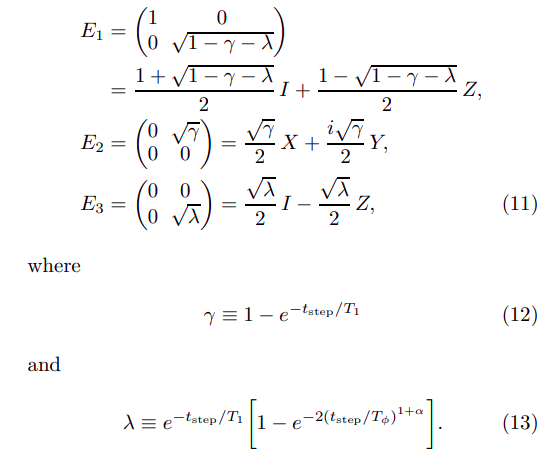

check if the decomposition of the above noise model into a pure dephasing noise + amplitude damping used for the monte carlo simulation works

In [6]:
def get_probs(duration, t1, t2):
    gamma = 1 - np.exp(-duration/t1)
    return gamma, (1 - gamma)*(1 - np.exp(-2*duration/t2))  

def get_kraus_ops(duration, t1, t2):
    gamma, lbda = get_probs(duration, t1, t2)
    E1 = np.array([[1, 0],[0, np.sqrt(1 - gamma - lbda)]])
    E2 = np.array([[0, np.sqrt(gamma)],[0, 0]])
    E3 = np.array([[0, 0],[0, np.sqrt(lbda)]])
    return E1, E2, E3

In [7]:
def get_dephasing_kraus_ops(duration, t2):
    lbda = 1 - np.exp(-2*duration/t2)
    alpha = (1+np.sqrt(1-lbda))/2
    E1 = np.array([[1, 0],[0, 1]])
    E2 = np.array([[0, 1],[1, 0]])
    E3 = np.array([[0, -1.0j], [1.0j, 0]])
    E4 = np.array([[1, 0],[0, -1]])
    # note the sqrt!
    p_I = np.sqrt(alpha)
    p_X = 0
    p_Y = 0
    p_Z = np.sqrt(1-alpha)
    
    return p_I*E1, p_X*E2, p_Y*E3, p_Z*E4    

In [8]:
def get_amplitude_damping_kraus_ops(duration, t1):
    gamma = 1-np.exp(-duration/t1)
    #note the sqrt!
    E1 = np.array([[1, 0],[0, np.sqrt(1-gamma)]])
    E2 = np.array([[0, np.sqrt(gamma)],[0, 0]])
    # in the monte carlo simulation we use an equivalent decomposition
    # https://arxiv.org/pdf/1703.00111.pdf
    return E1, E2

In [9]:
def get_pauli_twirling_kraus_ops(duration, t1, t2):
    p_X, p_Y, p_Z = get_pauli_probs(duration, t1, t2)
    p_I = 1 - p_X - p_Y - p_Z
    E1 = np.array([[1, 0],[0, 1]])
    E2 = np.array([[0, 1],[1, 0]])
    E3 = np.array([[0, -1.0j], [1.0j, 0]])
    E4 = np.array([[1, 0],[0, -1]])
    return np.sqrt(p_I)*E1, np.sqrt(p_X)*E2, np.sqrt(p_Y)*E3, np.sqrt(p_Z)*E4

In [10]:
psi = np.array([0.0 ,1.0])#np.random.rand(2) + np.random.rand(2)*1.0j
psi /= np.linalg.norm(psi)
rho = np.kron(psi, np.transpose(np.conj(psi))).reshape((2, 2))

In [11]:
def apply_kraus_ops(rho_i, ops):
    rho_f = 1.0j*np.zeros((2,2))
    for op in ops:
        rho_f += op@rho_i@np.transpose(np.conj(op))
    return rho_f

In [12]:
t1, t2 = 15e3, 19e3
duration = 600

rho_f = apply_kraus_ops(rho, get_dephasing_kraus_ops(duration, t2))
apply_kraus_ops(rho_f, get_amplitude_damping_kraus_ops(duration, t1))

array([[0.03921056+0.j, 0.        +0.j],
       [0.        +0.j, 0.96078944+0.j]])

In [13]:
apply_kraus_ops(rho, get_kraus_ops(duration, t1, t2))

array([[0.03921056+0.j, 0.        +0.j],
       [0.        +0.j, 0.96078944+0.j]])

In [14]:
apply_kraus_ops(rho, get_pauli_twirling_kraus_ops(duration, t1, t2))

array([[0.01960528+0.j, 0.        +0.j],
       [0.        +0.j, 0.98039472+0.j]])

The results match, so the probability amplitudes used in the monte carlo method are good and we take the same noise model (note that in stim we need the probabilities and not probability amplitudes). Any differences in the results should come from Pauli twirling approximation or statistical errors in the monte carlo approach (the number of necessary shots grows exponentially with the "negativity").